# Density Peak and clustering validation LAB.10 Solutions

In this lab we do cluster analysis and implement density peak clustering

In [1]:
import numpy as np  # for linear algebra
import pandas as pd # for dataframe manipulation
import matplotlib.pyplot as plt # for visualization
from scipy.spatial.distance import cdist # for distance calculation efficient
from sklearn.metrics.cluster import normalized_mutual_info_score # for checking
from clustering import KMeans # our implementation

import warnings
warnings.filterwarnings('ignore')

Let's start by downloading the dataset, and perform preprocessing

In [2]:
# extract data
data = pd.read_csv("../Datasets/Aggregation.txt", sep="\t", header=None).to_numpy()
# extract X and Y matrix
X = data[:, :-1]
Y = data[:, -1]

We now procede implementing Density Peaks. We first create an untility function to plot the decision graph, which helps to choose the number of clusters

In [3]:
class DensityPeakCluster(object):

    def __init__(self, dc_percentage = 0.1):
        
        # dc value if None, it is chosen automatically 
        self.dc_percentage = dc_percentage
        self.dc = None

    def fit(self, X):
        
        # extract number of data
        self._n_data = X.shape[0]

        # calculate distances
        self.distances, self.distance_matrix = self._build_distance(X)

        # calculate dc
        self._select_dc()

        # calculate density
        self._compute_density()

        # sort data and compute minimum 
        self._find_delta()

    def make_cluster(self, delta_threshold):
        
        # find centers
        self.centers = np.where(self.delta >= delta_threshold)[0]
        center_labels = np.arange(self.centers.shape[0])        

        # assign clusters
        clusters = np.zeros_like(self.density) - 1
        clusters[self.centers] = center_labels

        # sort density in decreasing order
        sort_idxs = np.argsort(-self.density)

        # assign clusters
        for idx in sort_idxs:
            if clusters[idx] == -1:
                clusters[idx] = clusters[int(self.neighs[idx])]

        self.clusters = clusters
        self.numb_clusters = len(self.centers)

    def _find_delta(self):
        # initialize delta
        delta = np.zeros_like(self.density)
        neighs = np.zeros_like(self.density)

        # sort density in decreasing order
        sort_idxs = np.argsort(-self.density)

        # assign delta values
        for i, idx in enumerate(sort_idxs):
            
            # skip the first since ill defined
            if i == 0:
                continue

            # check which one has minimum distance for the points with higher density
            index_higher_density = sort_idxs[:i]
            delta[idx] = np.min(self.distance_matrix[idx, index_higher_density])
            index_nn = np.argmin(self.distance_matrix[idx, index_higher_density])
            neighs[idx] = index_higher_density[index_nn].astype(int)
            
        # assign last point as 1.5 * max(delta)
        delta[sort_idxs[0]] = 1.5*np.max(delta)

        # assign
        self.delta = delta
        self.neighs = neighs

    def _compute_density(self):
        rho = np.zeros(self._n_data, dtype=float)
        for i in range(self._n_data-1):
            for j in range(i+1,self._n_data):
                rho[i] = rho[i] + np.exp(-(self.distance_matrix[i, j] / self.dc) ** 2)
                rho[j] = rho[j] + np.exp(-(self.distance_matrix[i, j] / self.dc) ** 2)
        self.density = rho
 
    def _build_distance(self, X):

        # extract distances
        distance_matrix = cdist(X, X, metric="euclidean")

        # assign distances in dict (just the upper triagular part)
        distance = {}
        for i in range(self._n_data):
            for j in range(i + 1, self._n_data):
                distance[(i, j)] = distance_matrix[i, j]
                distance[(j, i)] = distance_matrix[i, j]

        return distance,  distance_matrix

    def _select_dc(self):
        
         # take self.dc percentage of points
        position = int((self._n_data * (self._n_data + 1) / 2) * self.dc_percentage)
        # choose that distance
        self.dc = np.sort(list(self.distances.values()))[position * 2 + self._n_data]

    def plot_decision_graph(self):
        plt.xlabel(r'$\rho$')
        plt.ylabel(r'$\delta$')
        plt.plot(self.density, self.delta, 'o')
        plt.show()

    def plot_clusters(self, X):
        plt.scatter(X[:, 0], X[:, 1], c=self.clusters)
        centers = X[self.centers]
        plt.plot(centers[:, 0], centers[:, 1], 'kx')
        plt.show()


        

Let's try it out

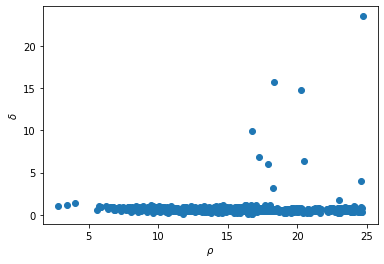

In [4]:
# create dp
dp = DensityPeakCluster(dc_percentage=0.02)
# fit dp
dp.fit(X)
# plot decision graph
dp.plot_decision_graph()


From the graph we can think to extract everything above 5.

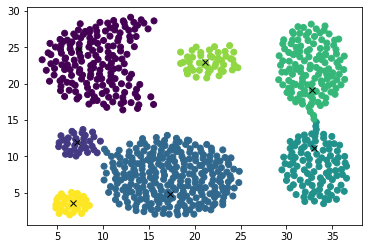

In [5]:
dp.make_cluster(delta_threshold=5)
dp.plot_clusters(X)

As we can see, we obtain very good clusters. We will now proceede to Normalized Mutual Information (NMI) and F-score

In [6]:
def entropy(labels):

    if len(labels) == 0:
        return 1.0

    # unique lables
    label_idx = np.unique(labels, return_inverse=True)[1]

    pi = np.bincount(label_idx).astype(np.float64)
    pi = pi[pi > 0]

    # zero entropy for single label
    if pi.size == 1:
        return 0.0

    # return entropy
    pi_sum = np.sum(pi)
    return -np.sum((pi / pi_sum) * (np.log(pi) - np.log(pi_sum)))



def NMI(labels_true, labels_predicted):

    n_elements = labels_true.shape[0]

    # extract features
    unique_true = np.unique(labels_true)
    unique_predicted = np.unique(labels_predicted)

    # storing the total sum
    numerator = 0
    denominator_1 = 0
    denominator_2 = 0

    # calculate MI
    for true in unique_true:
        for predicted in unique_predicted:
            mask = np.logical_and( (true == labels_true) ,  (predicted == labels_predicted) )
            prob_x_y = np.sum(mask) / n_elements
            prob_x = np.sum(true == labels_true) / n_elements
            prob_y = np.sum(predicted == labels_predicted) / n_elements 

            if prob_x_y == 0: # we assume 0 * log(0) = 0
                continue
            
            numerator += (prob_x_y * np.log( prob_x_y / (prob_x * prob_y) ))

    # calculate entropies
    return 2*numerator/(entropy(labels_true) + entropy(labels_predicted))

def fscore(X, labels):

    # xmean and data
    x_mean = np.mean(X, 0)
    data = np.hstack((X, labels.reshape(-1, 1)))

    # calculate center means
    centers = {}
    for i in np.unique(data[:,-1]):
        tmp = data[np.where(data[:,-1] == i)]
        centers[i] = np.mean(tmp[:, :-1], axis=0)

    # calculate number points
    numb_points = {}
    for i in np.unique(data[:,-1]):
        numb_points[i] = sum(data[:,-1] == i)

    # calculate ssw
    ssw = 0
    for i in range(data.shape[0]):
        label = data[i, -1]
        c = centers[label]
        # calculate distance point with its cluster center
        ssw += np.linalg.norm(c - data[i, :-1])**2

    # calculate SSB
    ssb = 0
    for i in np.unique(data[:,-1]):
        ssb += numb_points[i] * np.linalg.norm(centers[i] - x_mean)**2

    return len(np.unique(data[:,-1])) * (ssw / ssb)
    


Let's check with the skelearn implementations. First we check NMI score

In [7]:
np.allclose(NMI(Y, dp.clusters), normalized_mutual_info_score(Y, dp.clusters))

True

Now we check F-score, for real and obtained label

In [8]:
fscore(X, dp.clusters), fscore(X, Y)

(0.7579685047173924, 0.7591970240508631)

As we can see, they are both very similar...

Let's try how KMeans perform

In [9]:
print('KMeans results')
kmeans = KMeans(n_clusters=7, init='kmeans++')
kmeans.fit(X)
print(f'    f-score: {fscore(X, kmeans.labels)}')
print(f'    NMI: {NMI(Y, kmeans.labels)}')

print('Density Peak results')
print(f'    f-score: {fscore(X, dp.clusters)}')
print(f'    NMI: {NMI(Y, dp.clusters)}')

KMeans results
    f-score: 0.6699983773864929
    NMI: 0.8537713195247009
Density Peak results
    f-score: 0.7579685047173924
    NMI: 0.9956972087142976


As we can see, we have a higher NMI for density peak, but the f-score is lower.